In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openai transformers datasets torch scikit-learn -q
!pip install vaderSentiment afinn nltk pandas numpy -q
!pip install bertopic -q
!pip install gensim -q
#!pip install accelerate -q # for faster training

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 562.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [ ]:
import openai
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from datasets import Dataset
import json
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df_relevant = pd.read_parquet('drive/MyDrive/NLP/df_relevant.parquet', engine='pyarrow')
df_relevant.shape

(150466, 6)

In [ ]:
topic_info = pd.read_parquet('drive/MyDrive/NLP/bertopic_topic_info.parquet', engine='pyarrow')
topic_info.shape

(421, 5)

In [ ]:
pd.set_option('display.max_colwidth', 300)
topic_info.head(6)

,Topic,Count,Top_Words,Word_Scores,Percentage
0,0,2100,"overviewview, entertain ment, entertain, ment media, consumer, products, transportation, general, ment, financial services","[0.021049028105969834, 0.018428005227628236, 0.018332958583753306, 0.016735441638305336, 0.013671740218291952, 0.013559882914147451, 0.012962563467074435, 0.012768920681170004, 0.012507098939113415, 0.01178279697027111]",1.938450
1,1,1862,"newswires, presswire, ein presswire, ein, distribution, virginia, carolina, north, south, pricing","[0.030999986993161494, 0.024112336658085702, 0.02317454808035049, 0.022312425797662277, 0.015263016247810334, 0.014198002036419619, 0.014048248558535707, 0.013573557670618292, 0.013134368370301385, 0.011635145672863138]",1.718759
2,2,1672,"npr, radio, schedule, donate, programs, arts, listen, vehicle, 00, public","[0.024400916031937663, 0.01995010782029456, 0.019004480043976226, 0.01854764927937145, 0.01452684167729587, 0.013729334187101696, 0.013469112823607748, 0.012035804381721974, 0.011526168920887508, 0.010844535101871161]",1.543375
3,3,1276,"alert, television, opinions, views, country, weather, audio, provided, group, alerts","[0.016196012768748044, 0.014666791297778627, 0.011443863034853593, 0.011276728316835178, 0.010225792532783138, 0.010183120924338528, 0.01017559700540427, 0.009695762266667424, 0.008333419641612617, 0.00811281073036429]",1.177839
4,4,1128,"altman, sam altman, sam, openai, board, ceo, microsoft, founder, return, chief","[0.04518813254700077, 0.031217924904033807, 0.02980555239310463, 0.021998043136649072, 0.015075181737287472, 0.014790623743337897, 0.006462803008224538, 0.0062452309688572636, 0.005592089462766962, 0.005064591148835111]",1.041224
5,5,1025,"nvidia, chips, chip, pc, hardware, mar, aug, gaming, performance, 11","[0.03719338282218422, 0.012134164893987043, 0.009205998873729542, 0.007157271562934098, 0.00661396491220916, 0.005490797185949204, 0.005488411770111958, 0.005337948988395105, 0.005103867278782405, 0.005078327767134278]",0.946148


In [ ]:
pd.set_option('display.max_colwidth', 200)
df_relevant.head()

,url,date,language,title,text,text_word_count
0,https://caledoncitizen.com/artificial-intelligence/,2023-07-14,en,\r \t\t\t\t\t\t\t\t Artificial intelligence | Caledon Citizen\t\t\t\t\t\t\t\t\t,Artificial intelligence Caledon Citizen Members Log in Caledon Citizen Headline General Our Issues Current Issue Archived Issues Resale Homes Collections Progress Issues Current Progress Issue Pro...,1066
1,https://apolyton.net/forum/other-games/call-to-power-1/9470068-civilization-call-to-power-25th-anniversary-celebration-communities-fan-mods-ports-4k-ai-upscale-multiplayer-server-more,2024-05-05,en,"\r \t\t\r \t\t\tCivilization Call To Power 25th Anniversary Celebration - Communities, Fan Mods & Ports, 4K AI Upscale, Multiplayer Server, & More! - \r \t\t\r \t\tApolyton Civilization Site\r \t","Civilization Call To Power 25th Anniversary Celebration - Communities, Fan Mods Ports, 4K AI Upscale, Multiplayer Server, More! - Apolyton Civilization Site or Up Logging in... Log in or user name...",546
2,http://www.adaderana.lk/news.php?nid=109502,2025-06-15,en,\r \t\t AI workshop held at Temple Trees to enhance public service efficiency\t,"AI workshop held at Temple Trees to enhance public service efficiency June 15, 2025 Toggle navigation Hot Biz Tech Videos Archive TV FM Cinema Pulse AI workshop held at Temple Trees to enhance pub...",577
3,https://www.thecipherbrief.com/chinas-deepseek-breakthrough-and-what-it-means-for-national-security,2025-02-04,en,\r \t\tChina’s DeepSeek Breakthrough – and What it Means for National Security\t,China s DeepSeek Breakthrough and What it Means for National Security Open Source Reports Analysis Africa Asia Europe Latin America Middle East North America Tech Cyber Opinion s Podcasts State Se...,870
4,https://cornellsun.com/2023/08/30/colvin-ph-d-99-lamoreaux-01-to-discuss-impact-of-artificial-intelligence-on-workforce/,2023-08-31,en,"\r \t\tColvin Ph.D. ’99, LaMoreaux ’01 to Discuss Impact of Artificial Intelligence on Workforce | The Cornell Daily Sun\t","Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impact of Artificial Intelligence on Workforce The Cornell Daily Sun Thursday, August 31 Join The Sun! The Sun 161 Things Every Cornellian Should Do our iP...",849


## Assign BERTopic Models to Articles

In [ ]:
# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class BERTopicModelTrainer:
    def __init__(self, df=None, text_column='text', title_column='title', bertopic_model=None, **kwargs):
        """
        Initialize the BERTopic model trainer

        Args:
            df: DataFrame containing the text data (optional for loading saved models)
            text_column: Name of the column containing the main text
            title_column: Name of the column containing titles
            bertopic_model: Pre-trained BERTopic model (for loading saved models)
            **kwargs: Additional attributes for loading saved models
        """
        if df is not None:
            self.df = df.copy()
        else:
            self.df = None

        self.text_column = text_column
        self.title_column = title_column

        # For loading saved models
        if bertopic_model is not None:
            self.model = bertopic_model
            self.bertopic_model = bertopic_model  # Compatibility with recreated version
        else:
            self.model = None
            self.bertopic_model = None

        self.embeddings = None
        self.topics = None
        self.probabilities = None
        self.valid_indices = None

        # Set any additional attributes from kwargs (for loading saved models)
        for key, value in kwargs.items():
            setattr(self, key, value)

    def preprocess_text(self, text):
        """
        Basic text preprocessing
        """
        if pd.isna(text):
            return ""

        # Remove extra whitespace, tabs, newlines
        text = re.sub(r'\s+', ' ', str(text))
        # Remove special characters that might interfere
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        # Strip leading/trailing whitespace
        text = text.strip()
        return text

    def prepare_documents(self, df=None, combine_title_text=True):
        """
        Prepare documents for topic modeling

        Args:
            df: DataFrame to use (if None, uses self.df)
            combine_title_text: Whether to combine title and text columns
        """
        if df is None:
            df = self.df

        if df is None:
            raise ValueError("No DataFrame provided for document preparation")

        df_copy = df.copy()

        if combine_title_text and self.title_column in df_copy.columns:
            # Combine title and text with proper preprocessing
            df_copy['processed_title'] = df_copy[self.title_column].apply(self.preprocess_text)
            df_copy['processed_text'] = df_copy[self.text_column].apply(self.preprocess_text)

            # Combine title and text, giving more weight to title
            df_copy['combined_text'] = (
                df_copy['processed_title'] + '. ' + df_copy['processed_text']
            )
            documents = df_copy['combined_text'].tolist()
        else:
            documents = df_copy[self.text_column].apply(self.preprocess_text).tolist()

        # Filter out very short documents (less than 10 characters)
        valid_docs = [(i, doc) for i, doc in enumerate(documents) if len(doc.strip()) > 10]
        self.valid_indices = [i for i, _ in valid_docs]
        documents = [doc for _, doc in valid_docs]

        return documents

    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        """
        Split data into train, validation, and test sets

        Args:
            test_size: Proportion of data for test set
            val_size: Proportion of training data for validation set
            random_state: Random seed for reproducibility
        """
        if self.df is None:
            raise ValueError("No DataFrame available for splitting")

        # First split: separate test set
        train_val_df, test_df = train_test_split(
            self.df,
            test_size=test_size,
            random_state=random_state,
            stratify=None  # Can't stratify without known labels
        )

        # Second split: separate validation from training
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size,
            random_state=random_state
        )

        print(f"Data split completed:")
        print(f"Training set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        return train_df, val_df, test_df

    def create_model(self, n_neighbors=15, n_components=5, min_cluster_size=15,
                     min_samples=5, embedding_model='all-MiniLM-L6-v2'):
        """
        Create BERTopic model with custom parameters

        Args:
            n_neighbors: UMAP n_neighbors parameter
            n_components: UMAP n_components parameter
            min_cluster_size: HDBSCAN min_cluster_size parameter
            min_samples: HDBSCAN min_samples parameter
            embedding_model: Name of the sentence transformer model
        """
        # Initialize embedding model
        sentence_model = SentenceTransformer(embedding_model)

        # Initialize UMAP for dimensionality reduction
        umap_model = UMAP(
            n_neighbors=n_neighbors,
            n_components=n_components,
            min_dist=0.0,
            metric='cosine',
            random_state=42
        )

        # Initialize HDBSCAN for clustering
        hdbscan_model = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True
        )

        # Initialize CountVectorizer for topic representation
        vectorizer_model = CountVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2
        )

        # Create BERTopic model
        self.model = BERTopic(
            embedding_model=sentence_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=True
        )

        # For compatibility with recreated version
        self.bertopic_model = self.model

        return self.model

    def fit(self, texts=None):
        """
        Fit method for compatibility with recreated version

        Args:
            texts: List of texts to fit on (if None, prepares documents from self.df)
        """
        if texts is None:
            if self.df is None:
                raise ValueError("No texts provided and no DataFrame available")
            texts = self.prepare_documents()

        return self.train_model(texts)

    def train_model(self, documents):
        """
        Train the BERTopic model

        Args:
            documents: List of documents to train on
        """
        if self.model is None:
            raise ValueError("Model must be created before training. Call create_model() first.")

        print(f"Training BERTopic model on {len(documents)} documents...")

        # Fit the model and get topics
        self.topics, self.probabilities = self.model.fit_transform(documents)

        # Get embeddings for evaluation
        self.embeddings = self.model._extract_embeddings(documents)

        print(f"Model training completed!")
        print(f"Number of topics discovered: {len(set(self.topics)) - (1 if -1 in self.topics else 0)}")
        print(f"Number of outliers: {sum(1 for topic in self.topics if topic == -1)}")

        return self

    def transform(self, texts):
        """
        Transform method for compatibility with recreated version
        """
        return self.predict_topics(texts)

    def predict_topics(self, new_documents):
        """
        Predict topics for new documents

        Args:
            new_documents: List of new documents to predict topics for
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")

        try:
            # Try the standard transform method first
            topics, probabilities = self.model.transform(new_documents)
            return topics, probabilities
        except AttributeError as e:
            if "predict" in str(e):
                # HDBSCAN doesn't support prediction, use approximation method
                print("Using approximation method for topic prediction...")
                topics, probabilities = self.model.approximate_distribution(new_documents)
                return topics, probabilities
            else:
                raise e

    def assign_topics_to_dataframe(self, df, text_column=None, title_column=None, combine_title_text=True):
        """
        Assign topics to articles in a DataFrame

        Args:
            df: DataFrame containing articles
            text_column: Column containing text (uses self.text_column if None)
            title_column: Column containing titles (uses self.title_column if None)
            combine_title_text: Whether to combine title and text

        Returns:
            DataFrame with topic assignments
        """
        if self.model is None:
            raise ValueError("Model must be trained before assigning topics")

        # Use provided column names or defaults
        text_col = text_column or self.text_column
        title_col = title_column or self.title_column

        # Prepare documents
        df_copy = df.copy()

        if combine_title_text and title_col in df_copy.columns:
            # Combine title and text with proper preprocessing
            df_copy['processed_title'] = df_copy[title_col].apply(self.preprocess_text)
            df_copy['processed_text'] = df_copy[text_col].apply(self.preprocess_text)

            # Combine title and text
            df_copy['combined_text'] = (
                df_copy['processed_title'] + '. ' + df_copy['processed_text']
            )
            documents = df_copy['combined_text'].tolist()
        else:
            documents = df_copy[text_col].apply(self.preprocess_text).tolist()

        # Predict topics
        topics, probabilities = self.predict_topics(documents)

        # Add results to dataframe
        df_copy['topic'] = topics
        df_copy['topic_probability'] = [max(prob) if isinstance(prob, (list, np.ndarray)) else prob
                                       for prob in probabilities]

        # Add topic labels (top words)
        topic_labels = {}
        for topic_id in set(topics):
            if topic_id != -1:  # Skip outliers
                top_words = [word for word, _ in self.model.get_topic(topic_id)[:3]]
                topic_labels[topic_id] = ', '.join(top_words)
            else:
                topic_labels[topic_id] = 'Outlier'

        df_copy['topic_label'] = df_copy['topic'].map(topic_labels)

        return df_copy

    def calculate_coherence_score(self, documents, topics):
        """
        Calculate coherence score for the topics using Gensim's CoherenceModel
        """
        try:
            # Prepare documents for coherence calculation
            stop_words = set(stopwords.words('english'))

            # Tokenize and preprocess documents
            texts = []
            for doc in documents:
                # Simple tokenization and cleaning
                tokens = word_tokenize(doc.lower())
                # Remove stopwords and short tokens
                tokens = [token for token in tokens if token.isalpha() and
                         token not in stop_words and len(token) > 2]
                texts.append(tokens)

            # Create dictionary and corpus
            dictionary = Dictionary(texts)
            dictionary.filter_extremes(no_below=2, no_above=0.8)

            # Get topic words from BERTopic model
            topic_words = []
            unique_topics = sorted([t for t in set(topics) if t != -1])

            for topic_id in unique_topics:
                if topic_id in self.model.topic_representations_:
                    words = [word for word, score in self.model.get_topic(topic_id)[:10]]
                    # Filter words that exist in dictionary
                    words = [word for word in words if word in dictionary.token2id]
                    if len(words) >= 2:  # Need at least 2 words for coherence
                        topic_words.append(words)

            if len(topic_words) == 0:
                return 0.0

            # Calculate coherence score using C_V measure
            coherence_model = CoherenceModel(
                topics=topic_words,
                texts=texts,
                dictionary=dictionary,
                coherence='c_v'
            )

            coherence_score = coherence_model.get_coherence()
            return coherence_score

        except Exception as e:
            print(f"Warning: Could not calculate coherence score: {str(e)}")
            return 0.0

    def evaluate_model(self, documents=None, topics=None, embeddings=None):
        """
        Evaluate the model using various metrics
        """
        if topics is None:
            topics = self.topics
        if embeddings is None:
            embeddings = self.embeddings
        if documents is None:
            documents = []

        # Filter out outliers for clustering metrics
        valid_mask = np.array(topics) != -1
        valid_embeddings = embeddings[valid_mask] if embeddings is not None else None
        valid_topics = np.array(topics)[valid_mask]

        metrics = {}

        # Calculate coherence score (higher is better)
        if len(documents) > 0 and self.model is not None:
            coherence = self.calculate_coherence_score(documents, topics)
            metrics['coherence_score'] = coherence

        if valid_embeddings is not None and len(set(valid_topics)) > 1:  # Need at least 2 clusters
            # Calinski-Harabasz Score (higher is better)
            metrics['calinski_harabasz_score'] = calinski_harabasz_score(valid_embeddings, valid_topics)

            # Davies-Bouldin Score (lower is better)
            metrics['davies_bouldin_score'] = davies_bouldin_score(valid_embeddings, valid_topics)

        # Topic coherence and coverage metrics
        metrics['num_topics'] = len(set(topics)) - (1 if -1 in topics else 0)
        metrics['outlier_percentage'] = (sum(1 for topic in topics if topic == -1) / len(topics)) * 100
        metrics['largest_topic_size'] = max([sum(1 for t in topics if t == topic) for topic in set(topics)])

        return metrics

    def get_topic_info(self, n_words=10):
        """
        Get detailed information about discovered topics
        """
        if self.model is None:
            raise ValueError("Model must be trained before getting topic info")

        topic_info = []
        topic_freq = self.model.get_topic_freq()

        for _, row in topic_freq.iterrows():
            topic_id = row['Topic']
            if topic_id != -1:  # Skip outliers
                topic_words = self.model.get_topic(topic_id)[:n_words]
                words = [word for word, score in topic_words]
                scores = [score for word, score in topic_words]

                topic_info.append({
                    'Topic': topic_id,
                    'Count': row['Count'],
                    'Top_Words': ', '.join(words),
                    'Word_Scores': scores,
                    'Percentage': (row['Count'] / len(self.topics)) * 100
                })

        return pd.DataFrame(topic_info)

    def visualize_topics(self, top_n_topics=10):
        """
        Create visualizations for the topics
        """
        if self.model is None:
            raise ValueError("Model must be trained before visualization")

        # Topic frequency
        topic_freq = self.model.get_topic_freq()
        top_topics = topic_freq.head(top_n_topics)

        # Create subplot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Topic frequency bar plot
        ax1.bar(range(len(top_topics)), top_topics['Count'])
        ax1.set_xlabel('Topic')
        ax1.set_ylabel('Document Count')
        ax1.set_title(f'Top {top_n_topics} Topics by Document Count')
        ax1.set_xticks(range(len(top_topics)))
        ax1.set_xticklabels([f'Topic {t}' for t in top_topics['Topic']], rotation=45)

        # 2. Outlier percentage
        outlier_pct = (sum(1 for topic in self.topics if topic == -1) / len(self.topics)) * 100
        topic_pct = 100 - outlier_pct
        ax2.pie([topic_pct, outlier_pct], labels=['Assigned to Topics', 'Outliers'],
                autopct='%1.1f%%', startangle=90)
        ax2.set_title('Topic Assignment Distribution')

        # 3. Topic size distribution
        topic_sizes = [sum(1 for t in self.topics if t == topic) for topic in set(self.topics) if topic != -1]
        ax3.hist(topic_sizes, bins=20, edgecolor='black', alpha=0.7)
        ax3.set_xlabel('Topic Size')
        ax3.set_ylabel('Number of Topics')
        ax3.set_title('Distribution of Topic Sizes')

        # 4. Show top words for largest topics
        top_5_topics = topic_freq.head(5)['Topic'].tolist()
        topic_words = []
        for topic_id in top_5_topics:
            if topic_id != -1:
                words = [word for word, _ in self.model.get_topic(topic_id)[:5]]
                topic_words.append(f"Topic {topic_id}: {', '.join(words)}")

        ax4.axis('off')
        ax4.text(0.1, 0.9, 'Top 5 Topics - Key Words:', fontsize=14, fontweight='bold',
                transform=ax4.transAxes)
        for i, topic_word in enumerate(topic_words):
            ax4.text(0.1, 0.8 - i*0.15, topic_word, fontsize=10,
                    transform=ax4.transAxes, wrap=True)

        plt.tight_layout()
        plt.show()

        return fig


In [ ]:
def load_bertopic_with_custom_class(pickle_path):
    """
    Load BERTopic model with custom class definition
    """
    try:
        # Make sure the class is available in the current namespace
        globals()['BERTopicModelTrainer'] = BERTopicModelTrainer

        # Now try to load
        with open(pickle_path, 'rb') as f:
            trainer = pickle.load(f)
        print("✅ Successfully loaded BERTopicModelTrainer")

        # Extract the actual BERTopic model if it's wrapped
        if hasattr(trainer, 'model') and trainer.model is not None:
            bertopic_model = trainer.model
        elif hasattr(trainer, 'bertopic_model') and trainer.bertopic_model is not None:
            bertopic_model = trainer.bertopic_model
        else:
            bertopic_model = trainer  # In case the trainer itself is the model

        return trainer, bertopic_model

    except Exception as e:
        print(f"❌ Error loading with custom class: {e}")
        return None, None


In [ ]:
# 1. Load mysaved model
trainer, bertopic_model = load_bertopic_with_custom_class('drive/MyDrive/NLP/bertopic_trainer.pkl')

❌ Error loading with custom class: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.


In [ ]:
# 2. Assign topics to my articles
if trainer is not None:
    df_with_topics = trainer.assign_topics_to_dataframe(
        df_relevant,
        text_column='text',
        title_column='title',
        combine_title_text=False
    )

✅ Successfully loaded BERTopicModelTrainer


Batches:   0%|          | 0/4703 [00:00<?, ?it/s]

In [ ]:
# 3. View results
print("Topic assignment completed!")
print(f"Unique topics found: {df_with_topics['topic'].nunique()}")
print("\nSample results:")
print(df_with_topics[['topic', 'topic_label', 'topic_probability']].head())

Topic assignment completed!
Unique topics found: 422

Sample results:
   topic             topic_label  topic_probability
0     89     voice, money, phone           1.000000
1     -1                 Outlier           0.000000
2     14    india, indian, delhi           1.000000
3     65   chinese, china, model           0.811732
4    383  students, women, print           1.000000


In [ ]:
df_with_topics.head()

,url,date,language,title,text,text_word_count,topic,topic_probability,topic_label
0,https://caledoncitizen.com/artificial-intellig...,2023-07-14,en,\r \t\t\t\t\t\t\t\t Artificial intelligence |...,Artificial intelligence Caledon Citizen Member...,1066,89,1.000000,"voice, money, phone"
1,https://apolyton.net/forum/other-games/call-to...,2024-05-05,en,\r \t\t\r \t\t\tCivilization Call To Power 25t...,Civilization Call To Power 25th Anniversary Ce...,546,-1,0.000000,Outlier
2,http://www.adaderana.lk/news.php?nid=109502,2025-06-15,en,\r \t\t AI workshop held at Temple Trees to en...,AI workshop held at Temple Trees to enhance pu...,577,14,1.000000,"india, indian, delhi"
3,https://www.thecipherbrief.com/chinas-deepseek...,2025-02-04,en,\r \t\tChina’s DeepSeek Breakthrough – and Wha...,China s DeepSeek Breakthrough and What it Mean...,870,65,0.811732,"chinese, china, model"
4,https://cornellsun.com/2023/08/30/colvin-ph-d-...,2023-08-31,en,"\r \t\tColvin Ph.D. ’99, LaMoreaux ’01 to Disc...","Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impac...",849,383,1.000000,"students, women, print"


In [ ]:
# Save the resolved DataFrame to a CSV file
df_with_topics.to_csv('df_with_topics.csv', index=False)

# Provide a link to download the file
from google.colab import files
files.download('df_with_topics.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_with_topics.columns

Index(['url', 'date', 'language', 'title', 'text', 'text_word_count', 'topic',
       'topic_probability', 'topic_label'],
      dtype='object')

## Visualize Topic Distributions

Creating topic visualization...


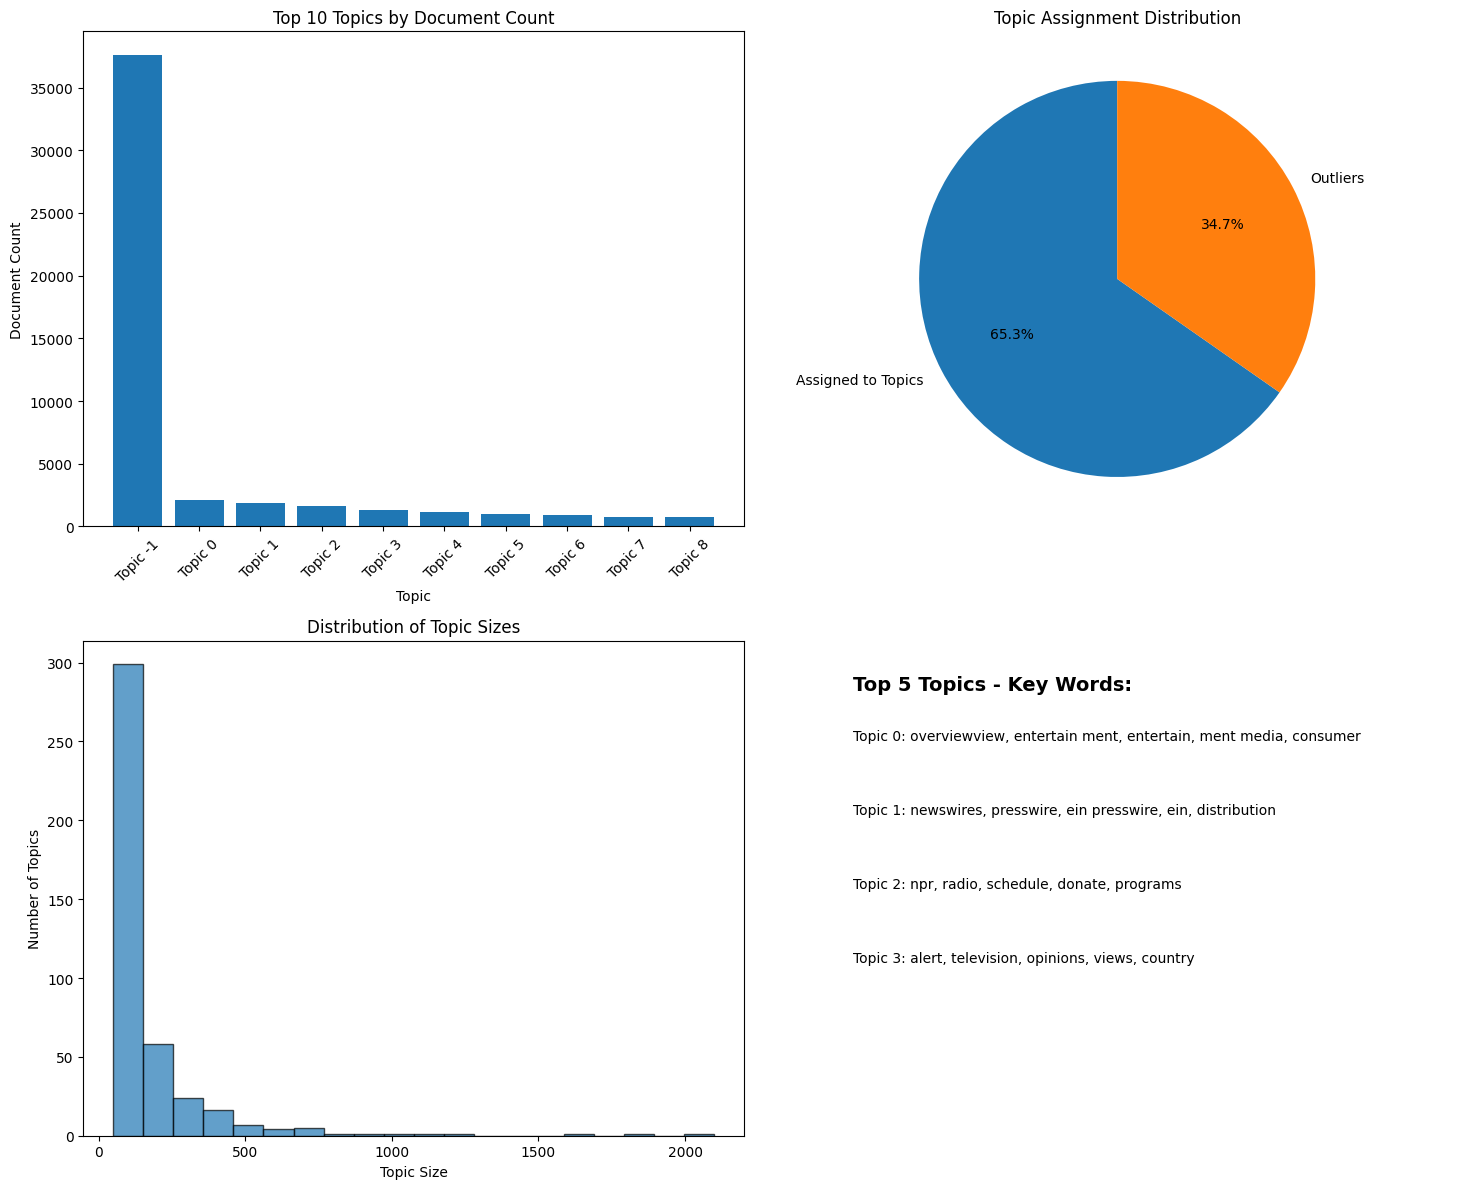

In [ ]:
if trainer is not None:
    # Basic visualization with default settings (top 10 topics)
    print("Creating topic visualization...")
    fig = trainer.visualize_topics()

In [ ]:
# Customize the number of topics to show
def visualize_with_different_topic_counts(trainer):
    """Show visualizations with different numbers of topics"""

    # Show top 5 topics
    print("\n=== Top 5 Topics ===")
    fig1 = trainer.visualize_topics(top_n_topics=5)

    # Show top 15 topics
    print("\n=== Top 15 Topics ===")
    fig2 = trainer.visualize_topics(top_n_topics=15)

    # Show all topics (or as many as discovered)
    num_topics = len(set(trainer.topics)) - (1 if -1 in trainer.topics else 0)
    print(f"\n=== All {num_topics} Topics ===")
    fig3 = trainer.visualize_topics(top_n_topics=num_topics)

    return fig1, fig2, fig3


=== Top 5 Topics ===


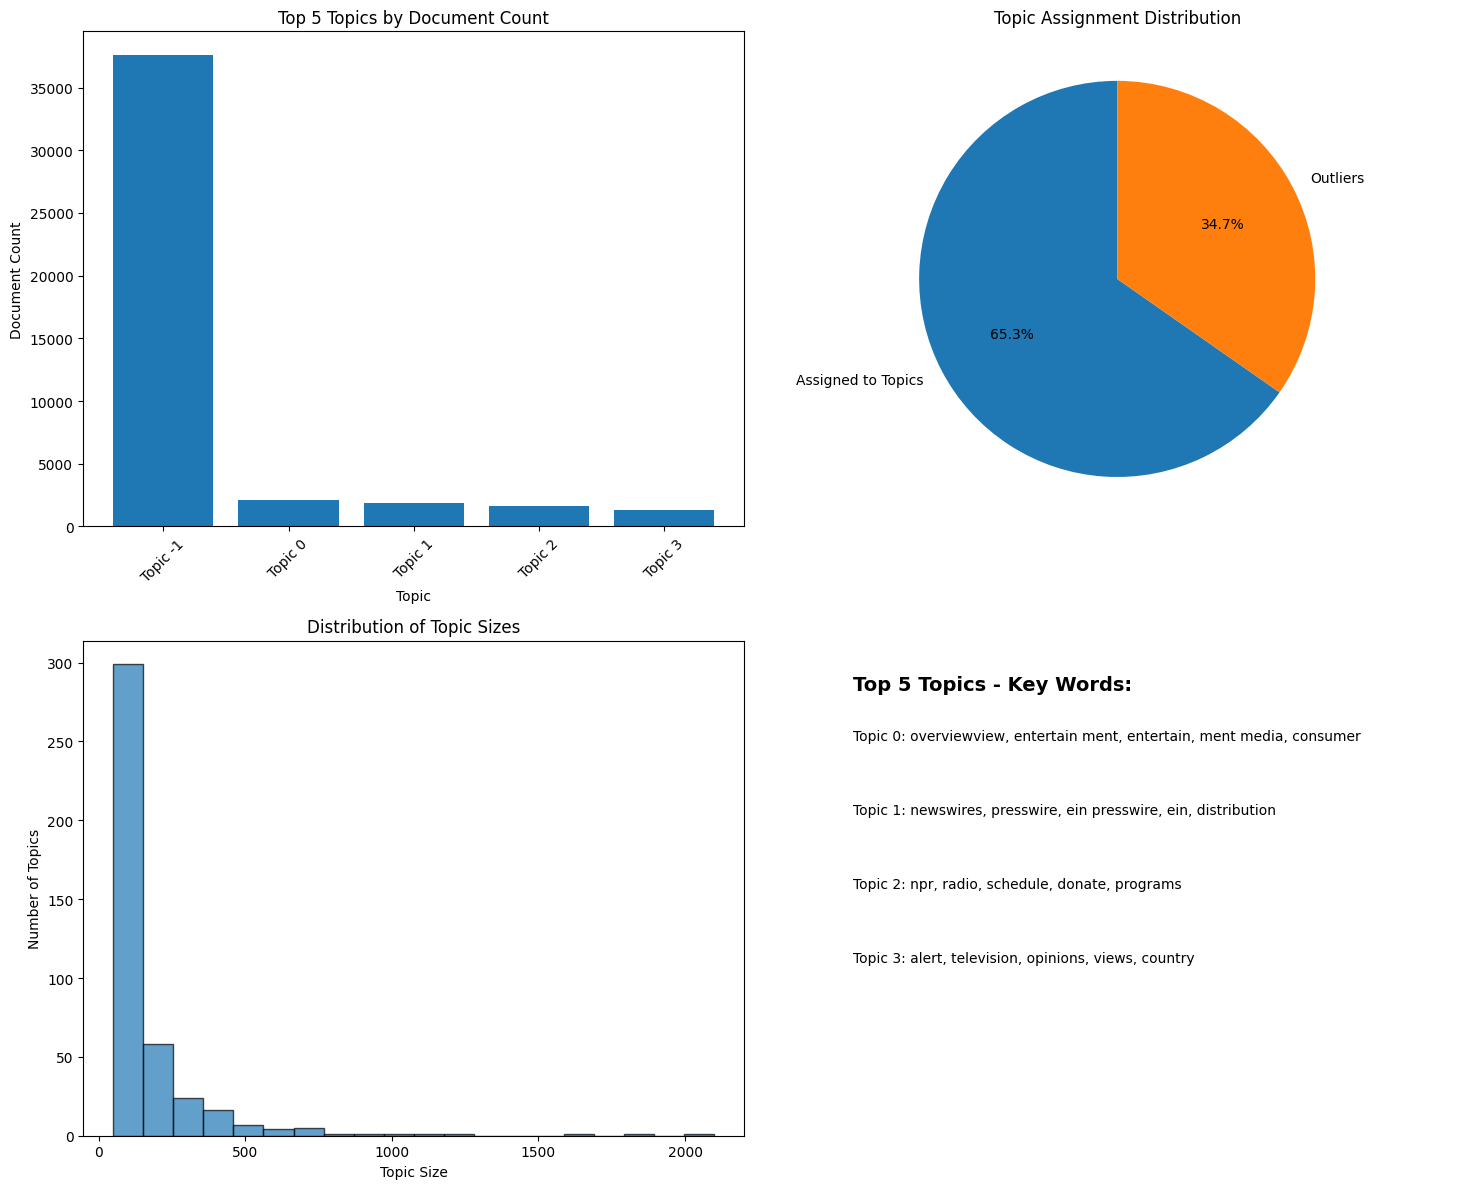


=== Top 15 Topics ===


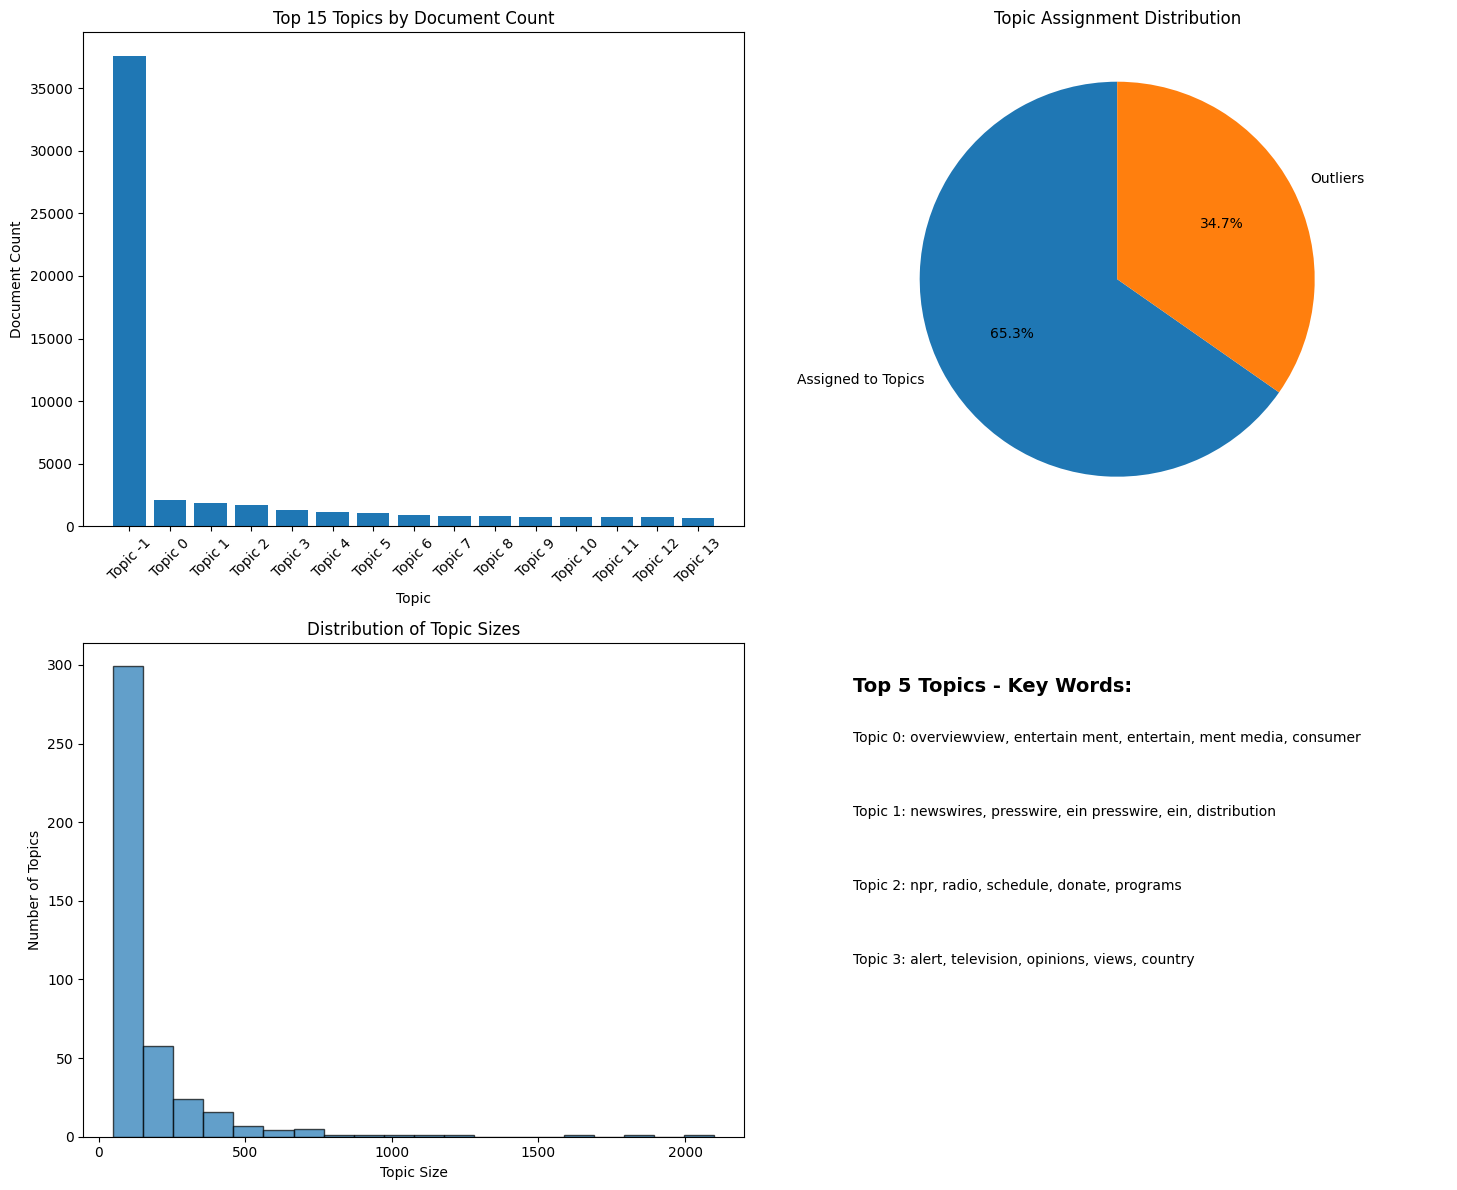


=== All 421 Topics ===


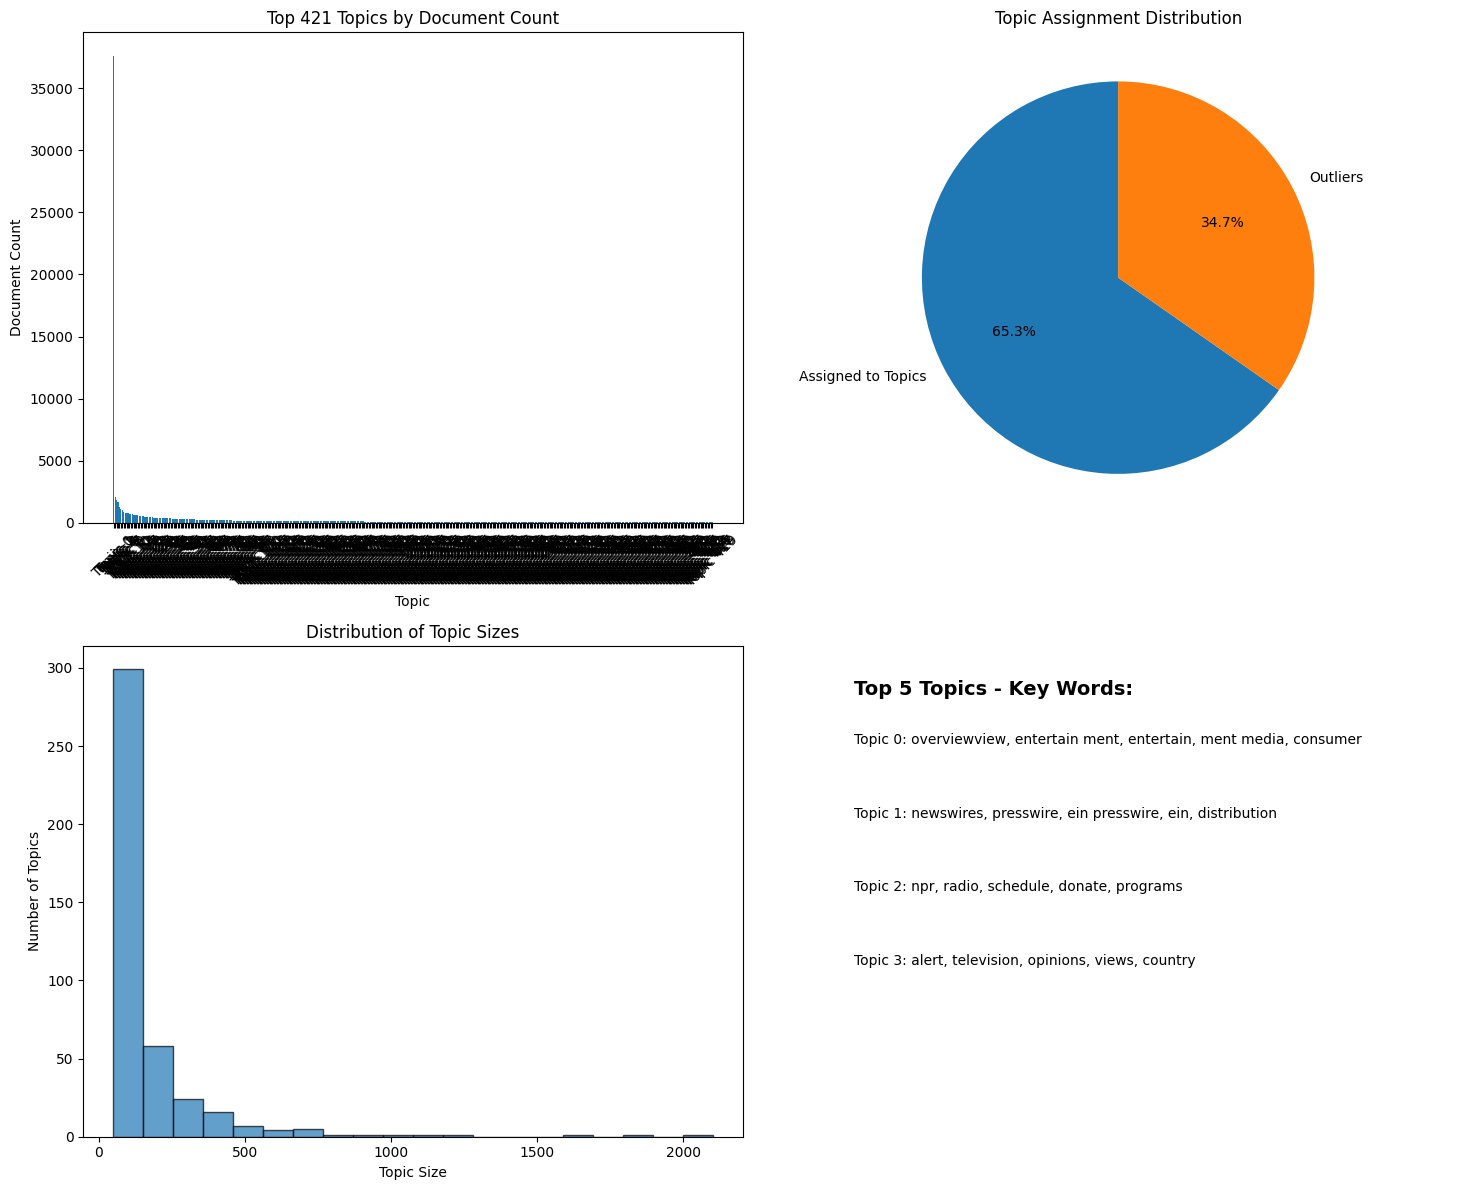

In [ ]:
fig1, fig2, fig3 = visualize_with_different_topic_counts(trainer)

## Develop Topic Sentiment Full Pipeline

In [ ]:
# Sentiment lexicon imports
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import nltk
try:
    from nltk.corpus import sentiwordnet as swn
    nltk.download('sentiwordnet', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    print("SentiWordNet not available, will skip in ensemble")

In [ ]:
class TopicSentimentAnalyzer:
    def __init__(self, openai_api_key: str):
        """
        Initialize the Topic-Level Sentiment Analyzer

        Args:
            openai_api_key: OpenAI API key for GPT-3.5 labeling
        """
        self.openai_client = openai.OpenAI(api_key=openai_api_key)
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.afinn = Afinn()
        self.fine_tuned_model = None
        self.tokenizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Determine device

    def create_labeling_prompt(self, text: str, topic_words: str) -> str:
        """
        Create a structured prompt for GPT-3.5 to label sentiment

        Args:
            text: The news article text to analyze
            topic_words: String of top words from BERTopic (e.g., "government, policy, election, political")
        """
        prompt = f"""
        You are a sentiment analysis expert. Analyze the sentiment of the following news article text,
        focusing on how the content relates to this topic.

        Topic represented by keywords: {topic_words}

        News Article Text:
        {text[:1500]}{"..." if len(text) > 1500 else ""}

        Instructions:
        1. Determine the sentiment of this article as it relates to the topic keywords above
        2. Consider the overall tone, not just individual words
        3. Classify as: POSITIVE, NEGATIVE, or NEUTRAL
        4. Provide confidence score (0.0-1.0)

        Respond in this exact JSON format:
        {{
            "sentiment": "POSITIVE/NEGATIVE/NEUTRAL",
            "confidence": 0.85,
            "explanation": "Brief reasoning"
        }}
        """
        return prompt

    def label_with_gpt35(self, df_sample: pd.DataFrame, topic_info: pd.DataFrame,
                        batch_size: int = 10, delay: float = 1.0) -> pd.DataFrame:
        """
        Label sentiment using GPT-3.5 with topic-aware prompting

        Args:
            df_sample: Sample of df_relevant['text'] to label (1000 rows)
                      Must have 'topic' column with topic IDs from BERTopic
            topic_info: DataFrame with columns ['Topic', 'Count', 'Top_Words', 'Word_Scores', 'Percentage']
            batch_size: Number of requests per batch
            delay: Delay between batches to respect rate limits
        """
        labeled_data = []

        # Create topic mapping: Topic ID -> Top_Words string
        # topic_info['Topic'] contains the topic IDs (-1, 0, 1, 2, ..., 426)
        # topic_info['Top_Words'] contains strings like "government, policy, political, election, minister"
        topic_to_words = dict(zip(topic_info['Topic'], topic_info['Top_Words']))

        print(f"Starting GPT-3.5 labeling for {len(df_sample)} samples...")
        print(f"Available topics: {len(topic_to_words)} topics")

        for idx, row in df_sample.iterrows():
            try:
                # Get the topic ID assigned by BERTopic (should be in df_sample)
                topic_id = row.get('topic', -1)  # -1 is outlier topic in BERTopic

                # Get the corresponding top words string for this topic
                topic_words = topic_to_words.get(topic_id, "general, news, article")

                prompt = self.create_labeling_prompt(row['text'], topic_words)

                response = self.openai_client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=200,
                    temperature=0.1
                )

                # Parse JSON response
                try:
                    result = json.loads(response.choices[0].message.content)
                    labeled_data.append({
                        'text': row['text'],
                        'topic': topic_id,
                        'sentiment': result['sentiment'],
                        'confidence': result['confidence'],
                        'explanation': result['explanation']
                    })
                except json.JSONDecodeError:
                    # Fallback parsing if JSON fails
                    content = response.choices[0].message.content
                    sentiment = "NEUTRAL"  # Default
                    if "POSITIVE" in content.upper():
                        sentiment = "POSITIVE"
                    elif "NEGATIVE" in content.upper():
                        sentiment = "NEGATIVE"

                    labeled_data.append({
                        'text': row['text'],
                        'topic': topic_id,
                        'sentiment': sentiment,
                        'confidence': 0.5,
                        'explanation': "Auto-parsed"
                    })

                # Rate limiting
                if len(labeled_data) % batch_size == 0:
                    print(f"Processed {len(labeled_data)} samples...")
                    time.sleep(delay)

            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                labeled_data.append({
                    'text': row['text'],
                    'topic': topic_id,
                    'sentiment': 'NEUTRAL',
                    'confidence': 0.0,
                    'explanation': f"Error: {str(e)}"
                })

        return pd.DataFrame(labeled_data)

    def prepare_training_data(self, labeled_df: pd.DataFrame) -> Tuple[Dataset, Dataset]:
        """
        Prepare data for fine-tuning transformer model
        """
        # Map sentiment labels to numbers
        label_map = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
        labeled_df['labels'] = labeled_df['sentiment'].map(label_map)

        # Split data
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            labeled_df['text'].tolist(),
            labeled_df['labels'].tolist(),
            test_size=0.2,
            random_state=42,
            stratify=labeled_df['labels']
        )

        # Create datasets
        train_dataset = Dataset.from_dict({
            'text': train_texts,
            'labels': train_labels
        })

        val_dataset = Dataset.from_dict({
            'text': val_texts,
            'labels': val_labels
        })

        return train_dataset, val_dataset

    def fine_tune_model(self, train_dataset: Dataset, val_dataset: Dataset,
                       model_name: str = "distilbert-base-uncased",
                       output_dir: str = "./topic-sentiment-model"):
        """
        Fine-tune a pre-trained transformer model
        """
        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3  # NEGATIVE, NEUTRAL, POSITIVE
        )

        # Move model to the determined device
        model.to(self.device)


        # Tokenize datasets
        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                truncation=True,
                padding=True,
                max_length=512
            )

        train_dataset = train_dataset.map(tokenize_function, batched=True)
        val_dataset = val_dataset.map(tokenize_function, batched=True)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f'{output_dir}/logs',
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
        )

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
        )

        # Train model
        print("Starting fine-tuning...")
        trainer.train()

        # Save model
        trainer.save_model(output_dir)
        self.fine_tuned_model = trainer.model

        print(f"Model fine-tuned and saved to {output_dir}")

    def prepare_sample_with_topics(self, df_relevant: pd.DataFrame,
                                  topic_info: pd.DataFrame, n_samples: int = 1000) -> pd.DataFrame:
        """
        Prepare a balanced sample from df_relevant that includes topic assignments

        Args:
            df_relevant: Your main dataframe with 'text' column and BERTopic results
                        Should have columns: ['text', 'topic'] where 'topic' contains BERTopic topic IDs
            topic_info: Your topic_info dataframe with columns ['Topic', 'Top_Words', etc.]
            n_samples: Number of samples to select for GPT-3.5 labeling

        Returns:
            DataFrame ready for GPT-3.5 labeling
        """

        # Ensure we have topic assignments
        if 'topic' not in df_relevant.columns:
            raise ValueError("df_relevant must have 'topic' column with BERTopic topic assignments")

        # Get topic distribution
        topic_counts = df_relevant['topic'].value_counts()
        print(f"Found {len(topic_counts)} unique topics in data")
        print(f"Topic distribution (top 10): \n{topic_counts.head(10)}")

        # Create stratified sample - proportional to topic frequency but with minimum samples per topic
        min_samples_per_topic = max(1, n_samples // (len(topic_counts) * 2))  # At least 1 sample per topic if possible
        max_samples_per_topic = n_samples // 5  # Cap to prevent one topic dominating

        sampled_data = []
        remaining_samples = n_samples

        # First pass: ensure each topic gets minimum representation
        for topic_id in topic_counts.index:
            if remaining_samples <= 0:
                break

            topic_data = df_relevant[df_relevant['topic'] == topic_id]
            n_topic_samples = min(min_samples_per_topic, len(topic_data), remaining_samples)

            if n_topic_samples > 0:
                sample = topic_data.sample(n=n_topic_samples, random_state=42)
                sampled_data.append(sample)
                remaining_samples -= n_topic_samples

        # Second pass: fill remaining slots proportionally
        if remaining_samples > 0:
            # Calculate proportional allocation for remaining samples
            for topic_id, count in topic_counts.head(20).items():  # Focus on top 20 topics
                if remaining_samples <= 0:
                    break

                topic_data = df_relevant[df_relevant['topic'] == topic_id]
                already_sampled = sum(len(df) for df in sampled_data if not df.empty and df['topic'].iloc[0] == topic_id)

                # Additional samples for this topic
                proportion = count / topic_counts.sum()
                additional_samples = min(
                    int(remaining_samples * proportion),
                    max_samples_per_topic - already_sampled,
                    len(topic_data) - already_sampled,
                    remaining_samples
                )

                if additional_samples > 0:
                    # Get samples not already selected
                    existing_indices = set()
                    for df in sampled_data:
                        if not df.empty and len(df[df['topic'] == topic_id]) > 0:
                            existing_indices.update(df[df['topic'] == topic_id].index)

                    available_data = topic_data[~topic_data.index.isin(existing_indices)]
                    if len(available_data) >= additional_samples:
                        additional_sample = available_data.sample(n=additional_samples, random_state=42)
                        sampled_data.append(additional_sample)
                        remaining_samples -= additional_samples


        # Combine all samples
        final_sample = pd.concat(sampled_data, ignore_index=True)

        # Shuffle the final sample
        final_sample = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

        print(f"Selected {len(final_sample)} samples for labeling")
        print(f"Topic distribution in sample:")
        print(final_sample['topic'].value_counts().head(10))

        return final_sample

    def load_fine_tuned_model(self, model_path: str):
        """Load a fine-tuned model"""
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.fine_tuned_model.to(self.device) # Move loaded model to device


    def get_lexicon_sentiment(self, text: str) -> Dict[str, float]:
        """
        Get sentiment scores from multiple lexicons
        """
        results = {}

        # VADER
        vader_scores = self.vader_analyzer.polarity_scores(text)
        results['vader'] = vader_scores['compound']

        # AFINN
        results['afinn'] = self.afinn.score(text) / 10.0  # Normalize to [-1, 1]

        # SentiWordNet (simplified implementation)
        try:
            words = nltk.word_tokenize(text.lower())
            pos_tags = nltk.pos_tag(words)
            swn_scores = []

            for word, pos in pos_tags:
                if pos.startswith('J'):  # Adjective
                    pos_tag = 'a'
                elif pos.startswith('V'):  # Verb
                    pos_tag = 'v'
                elif pos.startswith('N'):  # Noun
                    pos_tag = 'n'
                elif pos.startswith('R'):  # Adverb
                    pos_tag = 'r'
                else:
                    continue

                synsets = swn.senti_synsets(word, pos_tag)
                if synsets:
                    synset = synsets[0]
                    swn_scores.append(synset.pos_score() - synset.neg_score())

            results['sentiwordnet'] = np.mean(swn_scores) if swn_scores else 0.0

        except Exception as e:
            results['sentiwordnet'] = 0.0

        return results



    def ensemble_sentiment(self, text: str) -> Tuple[str, float, Dict]:
      """
      Combine multiple sentiment approaches for robust prediction
      """
      predictions = {}

      # Get lexicon scores
      lexicon_scores = self.get_lexicon_sentiment(text)
      predictions.update(lexicon_scores)

      # Get fine-tuned model prediction if available
      ft_confidence = 0.5  # Default confidence if no fine-tuned model
      if self.fine_tuned_model and self.tokenizer:
          inputs = self.tokenizer(text, return_tensors="pt", truncation=True,
                                padding=True, max_length=512)

          # Move inputs to the same device as the model
          inputs = {k: v.to(self.device) for k, v in inputs.items()}


          with torch.no_grad():
              outputs = self.fine_tuned_model(**inputs)
              probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
              predicted_class = torch.argmax(probabilities, dim=-1).item()
              ft_confidence = torch.max(probabilities).item()

          # Map to sentiment score
          class_to_score = {0: -1, 1: 0, 2: 1}  # NEG, NEU, POS
          predictions['fine_tuned'] = class_to_score[predicted_class]
          predictions['ft_confidence'] = ft_confidence

      # Ensemble prediction (weighted average)
      weights = {
          'vader': 0.3,
          'afinn': 0.2,
          'sentiwordnet': 0.2,
          'fine_tuned': 0.3
      }

      weighted_score = 0
      total_weight = 0

      for method, score in predictions.items():
          if method in weights and not pd.isna(score):
              # Ensure score is within [-1, 1] range
              score = max(-1, min(1, score))
              weighted_score += weights[method] * score
              total_weight += weights[method]

      if total_weight > 0:
          final_score = weighted_score / total_weight
      else:
          final_score = 0

      # Ensure final_score is within [-1, 1]
      final_score = max(-1, min(1, final_score))

      # Convert to categorical
      if final_score > 0.1:
          sentiment = 'POSITIVE'
      elif final_score < -0.1:
          sentiment = 'NEGATIVE'
      else:
          sentiment = 'NEUTRAL'

      # Calculate proper confidence based on multiple factors
      score_confidence = abs(final_score)  # How far from neutral (0)

      # If we have fine-tuned model, incorporate its confidence
      if 'ft_confidence' in predictions:
          # Combine score-based confidence with model confidence
          confidence = 0.6 * score_confidence + 0.4 * predictions['ft_confidence']
      else:
          confidence = score_confidence

      # Ensure confidence is in [0, 1] range
      confidence = max(0, min(1, confidence))

      return sentiment, confidence, predictions



    def analyze_topic_sentiment(self, df_with_topics: pd.DataFrame,
                               topic_info: pd.DataFrame) -> pd.DataFrame:
        """
        Perform topic-level sentiment analysis on all data
        """
        results = []

        print("Analyzing sentiment for all articles...")

        for idx, row in df_with_topics.iterrows():
            sentiment, confidence, details = self.ensemble_sentiment(row['text'])

            results.append({
                'article_id': idx,
                'topic': row.get('topic', -1),
                'sentiment': sentiment,
                'confidence': confidence,
                'text_length': len(row['text']),
                **details  # Include individual method scores
            })

            if len(results) % 1000 == 0:
                print(f"Processed {len(results)} articles...")

        return pd.DataFrame(results)

    def aggregate_theme_sentiment(self, sentiment_results: pd.DataFrame,
                                 topic_to_theme: Dict[int, str]) -> pd.DataFrame:
        """
        Aggregate topic-level sentiments to major theme level
        """
        # Add theme mapping
        sentiment_results['theme'] = sentiment_results['topic'].map(topic_to_theme)

        # Aggregate by theme
        theme_sentiment = []

        for theme in sentiment_results['theme'].unique():
            if pd.isna(theme):
                continue

            theme_data = sentiment_results[sentiment_results['theme'] == theme]

            # Calculate sentiment distribution
            sentiment_dist = theme_data['sentiment'].value_counts(normalize=True)
            avg_confidence = theme_data['confidence'].mean()

            # Calculate weighted sentiment score
            sentiment_scores = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
            weighted_score = sum([sentiment_scores[s] * count
                                for s, count in sentiment_dist.items()])

            theme_sentiment.append({
                'theme': theme,
                'total_articles': len(theme_data),
                'positive_pct': sentiment_dist.get('POSITIVE', 0),
                'neutral_pct': sentiment_dist.get('NEUTRAL', 0),
                'negative_pct': sentiment_dist.get('NEGATIVE', 0),
                'weighted_sentiment_score': weighted_score,
                'avg_confidence': avg_confidence
            })

        return pd.DataFrame(theme_sentiment)

In [ ]:
# Initialize analyzer
analyzer = TopicSentimentAnalyzer(openai_api_key="")

In [ ]:
# Step 1: Prepare balanced sample for GPT-3.5 labeling
print("Step 1: Preparing sample data for labeling...")
sample_data = analyzer.prepare_sample_with_topics(df_with_topics, topic_info, n_samples=1000)

Step 1: Preparing sample data for labeling...
Found 422 unique topics in data
Topic distribution (top 10): 
topic
-1     57115
 0      2935
 2      2330
 1      1978
 3      1828
 4      1386
 5      1275
 12     1044
 7      1041
 10      999
Name: count, dtype: int64
Selected 668 samples for labeling
Topic distribution in sample:
topic
-1     200
 0       8
 2       6
 3       5
 1       5
 4       4
 5       4
 9       3
 7       3
 10      3
Name: count, dtype: int64


In [ ]:
# Step 2: Label with GPT-3.5
print("Step 2: Labeling with GPT-3.5...")
labeled_data = analyzer.label_with_gpt35(sample_data, topic_info)

# Save labeled data
labeled_data.to_csv('gpt35_labeled_data.csv', index=False)

# Provide a link to download the file
from google.colab import files
files.download('gpt35_labeled_data.csv')

print(f"Labeled {len(labeled_data)} samples and saved to CSV")

Step 2: Labeling with GPT-3.5...
Starting GPT-3.5 labeling for 668 samples...
Available topics: 421 topics
Processed 10 samples...
Processed 20 samples...
Processed 30 samples...
Processed 40 samples...
Processed 50 samples...
Processed 60 samples...
Processed 70 samples...
Processed 80 samples...
Processed 90 samples...
Processed 100 samples...
Processed 110 samples...
Processed 120 samples...
Processed 130 samples...
Processed 140 samples...
Processed 150 samples...
Processed 160 samples...
Processed 170 samples...
Processed 180 samples...
Processed 190 samples...
Processed 200 samples...
Processed 210 samples...
Processed 220 samples...
Processed 230 samples...
Processed 240 samples...
Processed 250 samples...
Processed 260 samples...
Processed 270 samples...
Processed 280 samples...
Processed 290 samples...
Processed 300 samples...
Processed 310 samples...
Processed 320 samples...
Processed 330 samples...
Processed 340 samples...
Processed 350 samples...
Processed 360 samples...
Pr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Labeled 668 samples and saved to CSV


In [ ]:
labeled_data = pd.read_csv('drive/MyDrive/NLP/gpt35_labeled_data.csv')

In [ ]:
# Step 3: Fine-tune transformer model
print("Step 3: Fine-tuning transformer model...")
train_dataset, val_dataset = analyzer.prepare_training_data(labeled_data)
analyzer.fine_tune_model(train_dataset, val_dataset)

Step 3: Fine-tuning transformer model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function TopicSentimentAnalyzer.fine_tune_model.<locals>.tokenize_function at 0x785dcdb5f2e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/534 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Starting fine-tuning...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lexilin4263 (lexilin4263-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,1.026311
2,No log,0.885959
3,No log,0.807023


Model fine-tuned and saved to ./topic-sentiment-model


In [ ]:
df_with_topics = pd.read_csv('drive/MyDrive/NLP/df_with_topics.csv')

In [ ]:
# Step 4: Analyze sentiment for all articles using ensemble approach
print("Step 4: Analyzing sentiment for all articles...")
all_sentiment_results = analyzer.analyze_topic_sentiment(df_with_topics, topic_info)

# Save results
all_sentiment_results.to_csv('topic_level_sentiment.csv', index=False)
files.download('topic_level_sentiment.csv')

Step 4: Analyzing sentiment for all articles...
Analyzing sentiment for all articles...
Processed 1000 articles...
Processed 2000 articles...
Processed 3000 articles...
Processed 4000 articles...
Processed 5000 articles...
Processed 6000 articles...
Processed 7000 articles...
Processed 8000 articles...
Processed 9000 articles...
Processed 10000 articles...
Processed 11000 articles...
Processed 12000 articles...
Processed 13000 articles...
Processed 14000 articles...
Processed 15000 articles...
Processed 16000 articles...
Processed 17000 articles...
Processed 18000 articles...
Processed 19000 articles...
Processed 20000 articles...
Processed 21000 articles...
Processed 22000 articles...
Processed 23000 articles...
Processed 24000 articles...
Processed 25000 articles...
Processed 26000 articles...
Processed 27000 articles...
Processed 28000 articles...
Processed 29000 articles...
Processed 30000 articles...
Processed 31000 articles...
Processed 32000 articles...
Processed 33000 articles.

NameError: name 'files' is not defined

In [ ]:
article_level_sentiment = pd.read_csv('drive/MyDrive/NLP/topic_level_sentiment.csv')

In [ ]:
article_level_sentiment.head(10)

,article_id,topic,sentiment,confidence,text_length,vader,afinn,sentiwordnet
0,0,89,NEUTRAL,0.083243,5442,0.8609,-1.6,0.0
1,1,-1,POSITIVE,0.711157,3266,0.9927,8.1,0.0
2,2,14,NEUTRAL,0.050971,2641,0.4144,-0.8,0.0
3,3,65,POSITIVE,0.457043,4604,0.9331,0.2,0.0
4,4,383,POSITIVE,0.621029,4853,0.9824,0.7,0.0
5,5,130,NEGATIVE,0.713429,4650,-0.9980,-5.3,0.0
6,6,-1,POSITIVE,0.712486,6441,0.9958,4.1,0.0
7,7,166,POSITIVE,0.386371,2775,0.9682,-0.1,0.0
8,8,353,POSITIVE,0.713943,6656,0.9992,7.9,0.0
9,9,-1,POSITIVE,0.699629,4879,0.9658,1.9,0.0


In [ ]:
topic_info.head(10)

,Topic,Count,Top_Words,Word_Scores,Percentage
0,0,2100,"overviewview, entertain ment, entertain, ment ...","[0.021049028105969834, 0.018428005227628236, 0...",1.938450
1,1,1862,"newswires, presswire, ein presswire, ein, dist...","[0.030999986993161494, 0.024112336658085702, 0...",1.718759
2,2,1672,"npr, radio, schedule, donate, programs, arts, ...","[0.024400916031937663, 0.01995010782029456, 0....",1.543375
3,3,1276,"alert, television, opinions, views, country, w...","[0.016196012768748044, 0.014666791297778627, 0...",1.177839
4,4,1128,"altman, sam altman, sam, openai, board, ceo, m...","[0.04518813254700077, 0.031217924904033807, 0....",1.041224
5,5,1025,"nvidia, chips, chip, pc, hardware, mar, aug, g...","[0.03719338282218422, 0.012134164893987043, 0....",0.946148
6,6,885,"automation, data, enterprise, generative ai, g...","[0.006800712305633362, 0.006374372431037313, 0...",0.816918
7,7,782,"gpt, chatgpt, openai, users, gadgets, model, v...","[0.028711592251206057, 0.017517850885981665, 0...",0.721842
8,8,767,"humans, human, ai systems, intelligence, syste...","[0.012909409684082116, 0.010379944312309666, 0...",0.707996
9,9,761,"music, creative, audio, copyright, track, voic...","[0.03446744611561534, 0.005427468885699274, 0....",0.702457


In [ ]:
print("\n=== Overall Sentiment Distribution ===")
sentiment_dist = article_level_sentiment[article_level_sentiment['topic'] != -1]['sentiment'].value_counts()
print(sentiment_dist)


=== Overall Sentiment Distribution ===
sentiment
POSITIVE    82720
NEGATIVE     8182
NEUTRAL      2449
Name: count, dtype: int64


/tmp/ipython-input-2265587484.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_dist.index, y=sentiment_dist.values, palette='viridis')


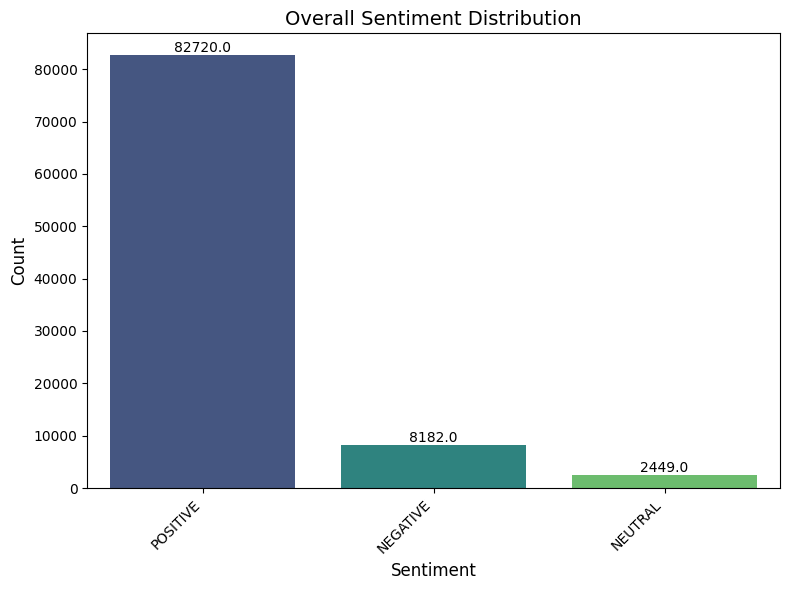

In [ ]:
# Plot the sentiment distribution as a bar chart with different colors
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_dist.index, y=sentiment_dist.values, palette='viridis')
plt.title('Overall Sentiment Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## Filter Sentiments by Confidence Level

In [ ]:
article_level_sentiment.head(20)

,article_id,topic,sentiment,confidence,text_length,vader,afinn,sentiwordnet,sentiment_numeric
0,0,89,NEUTRAL,0.088186,5442,0.8609,-1.6,0.0,0
1,1,-1,POSITIVE,2.739729,3266,0.9927,8.1,0.0,1
2,2,14,NEUTRAL,0.050971,2641,0.4144,-0.8,0.0,0
3,3,65,POSITIVE,0.457043,4604,0.9331,0.2,0.0,1
4,4,383,POSITIVE,0.621029,4853,0.9824,0.7,0.0,1
5,5,130,NEGATIVE,1.942000,4650,-0.9980,-5.3,0.0,-1
6,6,-1,POSITIVE,1.598200,6441,0.9958,4.1,0.0,1
7,7,166,POSITIVE,0.386371,2775,0.9682,-0.1,0.0,1
8,8,353,POSITIVE,2.685371,6656,0.9992,7.9,0.0,1
9,9,-1,POSITIVE,0.956771,4879,0.9658,1.9,0.0,1


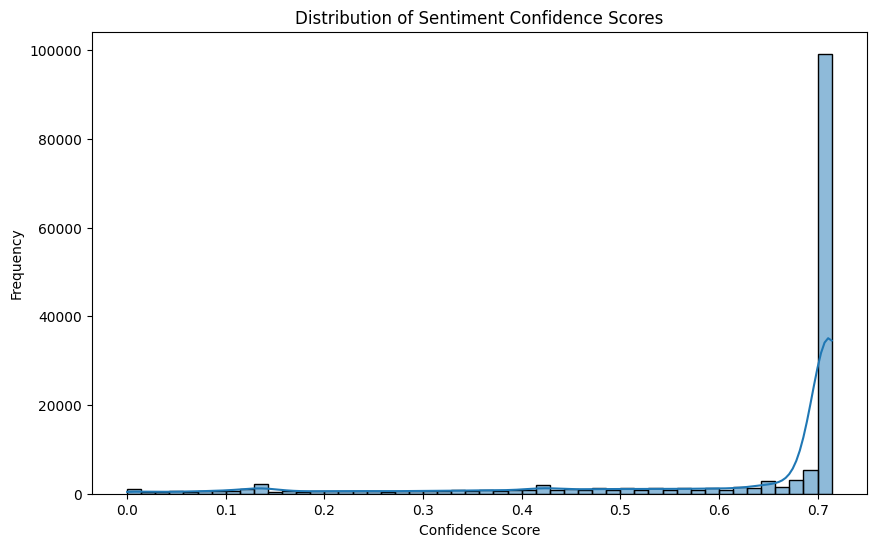

In [ ]:
# Plot the distribution of confidence scores
plt.figure(figsize=(10, 6))
sns.histplot(article_level_sentiment['confidence'], bins=50, kde=True)
plt.title('Distribution of Sentiment Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

## Find Sentiment for Each Topic

In [ ]:
# Method 1: Simple majority sentiment per topic
def get_topic_sentiment_majority(df):
    """
    Get the most common sentiment for each topic
    """
    topic_sentiment = df.groupby('topic')['sentiment'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'NEUTRAL').reset_index()
    topic_sentiment.columns = ['topic', 'dominant_sentiment']
    return topic_sentiment

# Method 2: Weighted by confidence scores
def get_topic_sentiment_weighted(df):
    """
    Calculate weighted sentiment based on confidence scores
    """
    # Create numeric sentiment values
    sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
    df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

    # Calculate weighted average sentiment per topic
    topic_weighted = df.groupby('topic').apply(
        lambda x: np.average(x['sentiment_numeric'], weights=x['confidence'])
    ).reset_index()
    topic_weighted.columns = ['topic', 'weighted_sentiment_score']

    # Convert back to categorical
    def score_to_sentiment(score):
        if score > 0.2:
            return 'POSITIVE'
        elif score < -0.2:
            return 'NEGATIVE'
        else:
            return 'NEUTRAL'

    topic_weighted['weighted_sentiment'] = topic_weighted['weighted_sentiment_score'].apply(score_to_sentiment)
    return topic_weighted

# Method 3: Using VADER scores (most reliable)
def get_topic_sentiment_vader(df):
    """
    Aggregate using VADER compound scores
    """
    topic_vader = df.groupby('topic').agg({
        'vader': ['mean', 'std', 'count'],
        'confidence': 'mean'
    }).round(4)

    # Flatten column names
    topic_vader.columns = ['vader_mean', 'vader_std', 'article_count', 'avg_confidence']
    topic_vader = topic_vader.reset_index()

    # Convert VADER scores to sentiment categories
    def vader_to_sentiment(score):
        if score >= 0.05:
            return 'POSITIVE'
        elif score <= -0.05:
            return 'NEGATIVE'
        else:
            return 'NEUTRAL'

    topic_vader['vader_sentiment'] = topic_vader['vader_mean'].apply(vader_to_sentiment)
    return topic_vader

# Method 4: Comprehensive analysis with multiple metrics
def comprehensive_topic_analysis(df):
    """
    Complete topic sentiment analysis with multiple approaches
    """
    # Filter out topics with -1 (which might represent uncategorized)
    df_filtered = df[df['topic'] != -1].copy()

    results = df_filtered.groupby('topic').agg({
        'sentiment': lambda x: x.mode().iloc[0],  # Most common sentiment
        'confidence': ['mean', 'std'],
        'vader': ['mean', 'std'],
        'afinn': ['mean', 'std'],
        'text_length': ['mean', 'count'],
        'article_id': 'nunique'  # Number of unique articles per topic
    }).round(4)

    # Flatten column names
    results.columns = [
        'dominant_sentiment', 'avg_confidence', 'std_confidence',
        'vader_mean', 'vader_std', 'afinn_mean', 'afinn_std',
        'avg_text_length', 'article_count', 'unique_articles'
    ]

    results = results.reset_index()

    # Add VADER-based sentiment classification
    results['vader_sentiment'] = results['vader_mean'].apply(
        lambda x: 'POSITIVE' if x >= 0.05 else ('NEGATIVE' if x <= -0.05 else 'NEUTRAL')
    )

    # Add AFINN-based sentiment classification
    results['afinn_sentiment'] = results['afinn_mean'].apply(
        lambda x: 'POSITIVE' if x > 0.5 else ('NEGATIVE' if x < -0.5 else 'NEUTRAL')
    )

    return results


**Aggregate Sentiment at the Topic Level**

Selected Method: Confidence-Weighted Sentiment

Weight each article's sentiment by its confidence score
More reliable articles (higher confidence) have more influence on the topic's overall sentiment

In [ ]:
# Method 1: Simple majority
majority_results = get_topic_sentiment_majority(article_level_sentiment)
print("1. Majority Sentiment per Topic:")
print(majority_results.head(10))
print()

# Method 2: Confidence-weighted
weighted_results = get_topic_sentiment_weighted(article_level_sentiment)
print("2. Confidence-Weighted Sentiment per Topic:")
print(weighted_results.head(10))
print()

1. Majority Sentiment per Topic:
   topic dominant_sentiment
0     -1           POSITIVE
1      0           POSITIVE
2      1           POSITIVE
3      2           POSITIVE
4      3           POSITIVE
5      4           POSITIVE
6      5           POSITIVE
7      6           POSITIVE
8      7           POSITIVE
9      8           POSITIVE

2. Confidence-Weighted Sentiment per Topic:
   topic  weighted_sentiment_score weighted_sentiment
0     -1                  0.831478           POSITIVE
1      0                  0.999481           POSITIVE
2      1                  0.992492           POSITIVE
3      2                  0.957851           POSITIVE
4      3                  0.953226           POSITIVE
5      4                  0.720328           POSITIVE
6      5                  0.949958           POSITIVE
7      6                  0.957877           POSITIVE
8      7                  0.927254           POSITIVE
9      8                  0.615214           POSITIVE



/tmp/ipython-input-3890690073.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topic_weighted = df.groupby('topic').apply(


In [ ]:
# Method 3: VADER-based
vader_results = get_topic_sentiment_vader(article_level_sentiment)
print("3. VADER-based Sentiment per Topic:")
print(vader_results.head(10))
print()

# Method 4: Comprehensive analysis
comprehensive_results = comprehensive_topic_analysis(article_level_sentiment)
print("4. Comprehensive Topic Analysis:")
print(comprehensive_results.head(10))


3. VADER-based Sentiment per Topic:
   topic  vader_mean  vader_std  article_count  avg_confidence vader_sentiment
0     -1      0.7725     0.5376          57115          0.6150        POSITIVE
1      0      0.9981     0.0428           2935          0.7119        POSITIVE
2      1      0.9891     0.1191           1978          0.7058        POSITIVE
3      2      0.9183     0.3239           2330          0.6748        POSITIVE
4      3      0.8679     0.3074           1828          0.5992        POSITIVE
5      4      0.6437     0.6409           1386          0.5748        POSITIVE
6      5      0.8910     0.3396           1275          0.6454        POSITIVE
7      6      0.9285     0.3036            998          0.6694        POSITIVE
8      7      0.8489     0.4151           1041          0.6400        POSITIVE
9      8      0.6042     0.7196            995          0.5912        POSITIVE

4. Comprehensive Topic Analysis:
   topic dominant_sentiment  avg_confidence  std_confidence  

In [ ]:
topic_sentiment_dist_1 = vader_results[vader_results['topic'] != -1]['vader_sentiment'].value_counts()
print(topic_sentiment_dist_1)

vader_sentiment
POSITIVE    412
NEGATIVE      5
NEUTRAL       4
Name: count, dtype: int64


In [ ]:
print("\n=== Topic Level Sentiment Distribution ===")
topic_sentiment_dist = weighted_results[weighted_results['topic'] != -1]['weighted_sentiment'].value_counts()
print(topic_sentiment_dist)


=== Topic Level Sentiment Distribution ===
weighted_sentiment
POSITIVE    397
NEUTRAL      18
NEGATIVE      6
Name: count, dtype: int64


In [ ]:
topic_sentiment_dist = pd.DataFrame({'Sentiment': topic_sentiment_dist.index, 'Count': topic_sentiment_dist.values})
print(topic_sentiment_dist)

  Sentiment  Count
0  POSITIVE    390
1   NEUTRAL     21
2  NEGATIVE     10


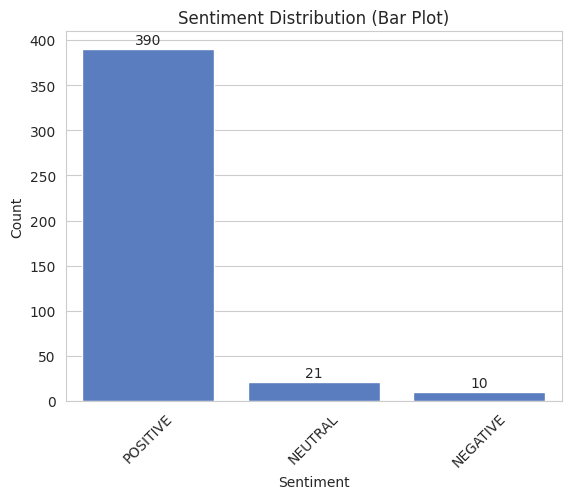

In [ ]:
# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("muted")  # Colorblind-friendly palette


# 1. Bar Plot
sns.barplot(x='Sentiment', y='Count', data=topic_sentiment_dist)
plt.title('Sentiment Distribution (Bar Plot)', fontsize=12)
plt.xlabel('Sentiment', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45)
for i, count in enumerate(topic_sentiment_dist['Count']):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10)


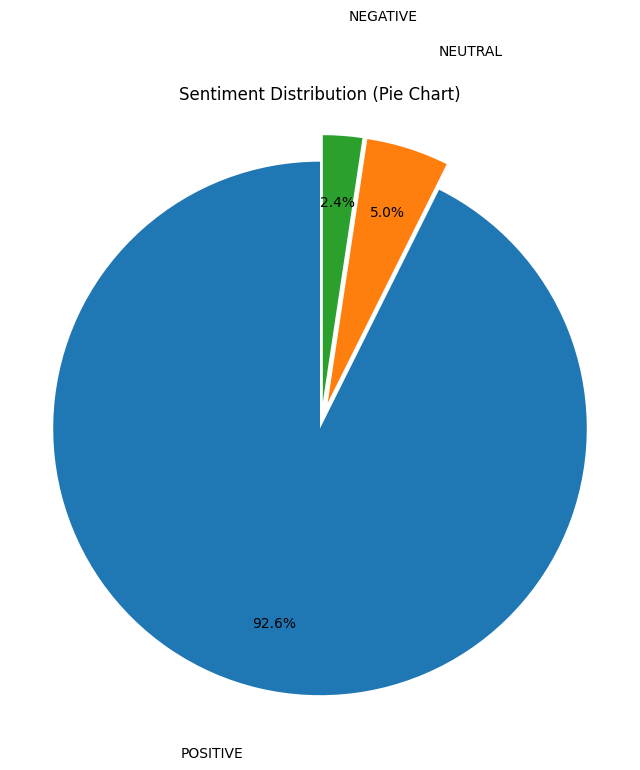

In [ ]:
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(topic_sentiment_dist['Count'],
                                  labels=topic_sentiment_dist['Sentiment'],
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  labeldistance=1.25,  # Increased from 1.1
                                  pctdistance=0.75,    # Decreased from 0.8
                                  explode=(0.02, 0.08, 0.08),  # Separate small slices
                                  textprops={'fontsize': 10})

# Manually adjust problematic labels
for i, text in enumerate(texts):
    if i == 1:  # NEGATIVE
        x, y = text.get_position()
        text.set_position((x * 1.1, y * 1.1))
    elif i == 2:  # NEUTRAL
        x, y = text.get_position()
        text.set_position((x * 1.05, y * 1.15))

plt.title('Sentiment Distribution (Pie Chart)', fontsize=12)
plt.axis('equal')
plt.show()